In [1]:
import numpy as np
import matplotlib.pyplot as plt
from myVNS import MyVNS
from myProblem import MyProblem
from datetime import datetime
import csv
import pandas as pd

class Struct:
    pass

# Loop principal começa aqui

Rodando execução 1...
Rodando numero 1 ε = 1048.17 em 2025-06-01 16:40:39.327690
Rodando numero 2 ε = 1084.87 em 2025-06-01 16:41:22.578966
Rodando numero 3 ε = 1121.57 em 2025-06-01 16:42:08.775429
Rodando numero 4 ε = 1158.27 em 2025-06-01 16:42:52.892388
Rodando numero 5 ε = 1194.97 em 2025-06-01 16:43:38.311454
Rodando numero 6 ε = 1231.68 em 2025-06-01 16:44:20.674397
Rodando numero 7 ε = 1268.38 em 2025-06-01 16:45:03.373212
Rodando numero 8 ε = 1305.08 em 2025-06-01 16:45:46.838878
Rodando numero 9 ε = 1341.78 em 2025-06-01 16:46:29.654930
Rodando numero 10 ε = 1378.48 em 2025-06-01 16:47:11.757584
Rodando numero 11 ε = 1415.18 em 2025-06-01 16:47:54.723201
Rodando numero 12 ε = 1451.88 em 2025-06-01 16:48:37.156477
Rodando numero 13 ε = 1488.58 em 2025-06-01 16:49:19.269900
Rodando numero 14 ε = 1525.28 em 2025-06-01 16:50:04.650011
Rodando numero 15 ε = 1561.98 em 2025-06-01 16:50:39.752295
Rodando numero 16 ε = 1598.69 em 2025-06-01 16:51:27.485069
Rodando numero 17 ε = 1635.

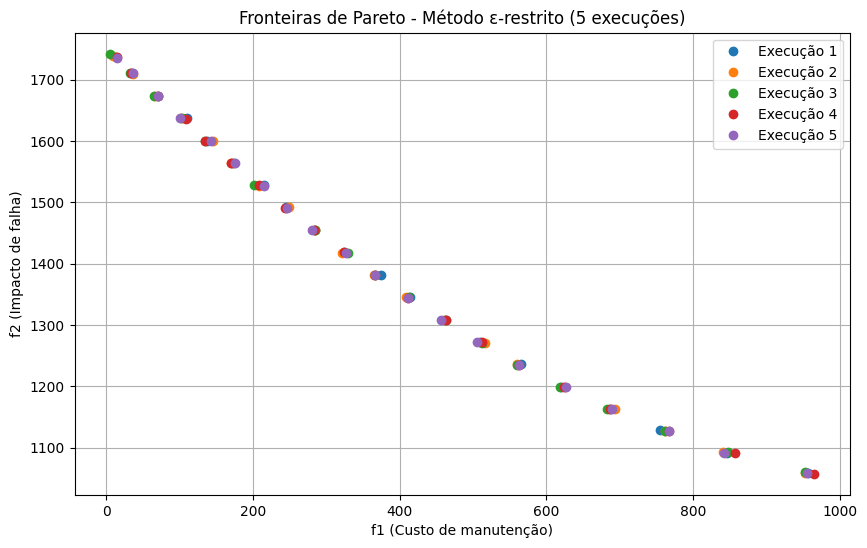

In [2]:
import matplotlib.pyplot as plt
import numpy as np

num_execucoes = 5
max_num_sol_avaliadas = 1000
kmax = 3

convergencias = []
melhores_fitness = []

# gera os epsilons
min_f2 = 1048.17
max_f2 = 1745.49
number_of_epsilons = 20
epsilons = np.linspace(min_f2, max_f2, number_of_epsilons)

historico_fronteira = Struct()
historico_fronteira.f1 = []
historico_fronteira.f2 = []
solucoes_pareto = []

def is_convergence_good(history, tol_size, tol):
    if len(history) < 10:
        return False  # or handle this case as needed
       
    last_tol = history[-tol_size:]  # Get the last tol_size elements
    std = np.std(last_tol)

    return std < tol

for execucao in range(num_execucoes):
    print(f'Rodando execução {execucao + 1}...')

    f1_solucoes = []
    f2_solucoes = []

    for t in range(number_of_epsilons):
        epsilon = epsilons[t]
        print(f'Rodando numero {t + 1} ε = {epsilon:.2f} em {datetime.now()}')

        # Cria instâncias dos objetos
        myProblem = MyProblem()
        myVNS = MyVNS()

        # Gera os dados do problema
        probdata = myProblem.probdef()
        probdata.epsilon = epsilon

        # Gera uma solução inicial
        sol_inicial = myProblem.sol_inicial(probdata, apply_constructive_heuristic=False)

        # Escolhe a função objetivo
        func_obj = myProblem.fobj_epsilon_restrito  # Troque para fobj1 se quiser

        fitness_sol_inicial = func_obj(sol_inicial, probdata)
        num_sol_avaliadas = 1

        historico = Struct()

        historico.sol = []
        historico.fit = []
        historico.sol.append(sol_inicial)
        historico.fit.append(myProblem.fobj1(sol_inicial, probdata))

        sol_atual = sol_inicial
        fitness_atual = fitness_sol_inicial

        # loop principal (BVNS)
        tol = 10**(-5) # desvio padrao
        tol_iteractions = 100

        # se nas ultimas tol_iteractions a diferenca entre os fitness for menor que tol, para

        while num_sol_avaliadas < max_num_sol_avaliadas:
            k = 1
            previous_fitness = 0
            stop_flag = False
            while k <= kmax:
                num_sol_avaliadas += 1

                # Gera uma solução candidata na k-ésima vizinhança de x 
                sol_candidata = myVNS.shake(sol_atual, k, probdata)

                # faz uma busca local a partir da solução candidata do shake
                # sol_local = myVNS.firstImprovement(sol_candidata, probdata, func_obj, k)
                sol_local = myVNS.bestImprovement(sol_candidata, probdata, func_obj, k)

                # Atualiza solução corrente e estrutura de vizinhança (se necessário)
                x, k = myVNS.neighborhoodChange(sol_atual, sol_local, k, func_obj, probdata)

                sol_atual = x
                fitness_atual = func_obj(sol_atual, probdata)

                # dados para plot
                historico.sol.append(sol_atual)
                historico.fit.append(myProblem.fobj1(sol_atual, probdata))

                # checa a convergencia
                if is_convergence_good(historico.fit, tol_iteractions, tol):
                    stop_flag = True
                    break
                else:
                    previous_fitness = myProblem.fobj1(sol_atual, probdata)

            if stop_flag: 
                break

        # melhor solucao encontrada:
        f1_solucoes.append(myProblem.fobj1(sol_atual, probdata))
        f2_solucoes.append(myProblem.fobj2(sol_atual, probdata))
        solucoes_pareto.append(sol_atual)

    historico_fronteira.f1.append(f1_solucoes)
    historico_fronteira.f2.append(f2_solucoes)


dados_resultado = []

for i in range(len(solucoes_pareto)):
    linha = {}
    solucao = solucoes_pareto[i]
    for j, valor in enumerate(solucao):
        linha[f'x{j}'] = valor+1
    dados_resultado.append(linha)

df_resultado = pd.DataFrame(dados_resultado)

# Gera nome do arquivo com data e hora atual
datahora = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
nome_arquivo = f'resultados_pareto_epsilon_rest_penalidade_{datahora}.csv'

# Salva o DataFrame como CSV
df_resultado.to_csv(nome_arquivo, index=False)
print(f'\nArquivo salvo: {nome_arquivo}')


# Plotagem dos resultados
plt.figure(figsize=(10, 6))
for i in range(num_execucoes):
    plt.plot(historico_fronteira.f1[i], historico_fronteira.f2[i], 'o', label=f'Execução {i+1}')
plt.title('Fronteiras de Pareto - Método ε-restrito (5 execuções)')
plt.xlabel('f1 (Custo de manutenção)')
plt.ylabel('f2 (Impacto de falha)')
plt.grid(True)
plt.legend()
plt.show()


